In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

# 中文字体设置 Chinese Font Setting
from matplotlib.font_manager import FontProperties
font_ch = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=12)
font_en = FontProperties(fname=r"c:\windows\fonts\times.ttf", size=12)



In [ ]:
import numpy as np

class Experiment:
    """加载 .npz 文件为类属性，不改变原始格式"""

    def __init__(self, path, method_label):
        self.method_label = method_label
        data = np.load(path, allow_pickle=True)

        # 普通变量直接赋值
        
        self.all_state    = data['all_state']
        self.input_term   = data['input_term']
        self.output_term  = data['output_term']
        self.all_pred_y1  = data['all_pred_y1']
        self.all_pred_y2  = data['all_pred_y2']
        self.all_pred_u1  = data['all_pred_u1']
        self.all_pred_u2  = data['all_pred_u2']
        self.all_pred_u3  = data['all_pred_u3']
        self.all_pred_u4  = data['all_pred_u4']
        self.set_y1       = data['set_y1']
        self.set_y2       = data['set_y2']

        # 特殊对象（如 scaler）用 .item()
        self.scalers            = data['scalers'].item()
        self.input_term_limits  = data['input_term_limits'].item()

        print(f"✅ {self.method_label} 加载完成")



In [52]:
# ===== 四组实验数据 =====
exp_SC_MLP_AUM_SCOP         = Experiment('神经网络_当前输出分类4_有子模态.npz'    , 'SC-MLP-AUM-SCOP')
exp_SC_MLP_AUM              = Experiment('神经网络_当前输出分类4_无子模态.npz'    , 'SC-MLP-AUM')

✅ SC-MLP-AUM-SCOP 加载完成
✅ SC-MLP-AUM 加载完成


In [53]:
def inverse_transform_and_evaluate(exp, startt=0, endd=None):
    """
    对传入的实验对象 exp 执行反归一化与误差计算，
    并将结果（y1_pred_inverse 等）存回 exp 内部。
    """
    
    # ✅ 现在 exp_SC_MLP_AUM_SCOP 内部多了这些属性：
    # exp_SC_MLP_AUM_SCOP.y1_pred_inverse
    # exp_SC_MLP_AUM_SCOP.y2_pred_inverse
    # exp_SC_MLP_AUM_SCOP.u1_pred_inverse
    # exp_SC_MLP_AUM_SCOP.u_limits
    # exp_SC_MLP_AUM_SCOP.rmse_y1 / exp_SC_MLP_AUM_SCOP.rmse_y2



    if endd is None:
        endd = len(exp.set_y1)

    # ====== 数据反归一化 ======
    exp.y1_pred_inverse = exp.scalers[exp.output_term[0]].inverse_transform(
        np.array(exp.all_pred_y1[startt:endd]).reshape(-1, 1)
    ).flatten()

    exp.y2_pred_inverse = exp.scalers[exp.output_term[1]].inverse_transform(
        np.array(exp.all_pred_y2[startt:endd]).reshape(-1, 1)
    ).flatten()

    exp.u1_pred_inverse = exp.scalers[exp.input_term[0]].inverse_transform(
        np.array(exp.all_pred_u1[startt:endd]).reshape(-1, 1)
    ).flatten()
    exp.u2_pred_inverse = exp.scalers[exp.input_term[1]].inverse_transform(
        np.array(exp.all_pred_u2[startt:endd]).reshape(-1, 1)
    ).flatten()
    exp.u3_pred_inverse = exp.scalers[exp.input_term[2]].inverse_transform(
        np.array(exp.all_pred_u3[startt:endd]).reshape(-1, 1)
    ).flatten()
    exp.u4_pred_inverse = exp.scalers[exp.input_term[3]].inverse_transform(
        np.array(exp.all_pred_u4[startt:endd]).reshape(-1, 1)
    ).flatten()

    # ====== 控制量上下限 ======
    exp.u_limits = {
        'u1': exp.scalers[exp.input_term[0]].inverse_transform(np.array([1, -1]).reshape(-1, 1)).flatten(),
        'u2': exp.scalers[exp.input_term[1]].inverse_transform(np.array([1, -1]).reshape(-1, 1)).flatten(),
        'u3': exp.scalers[exp.input_term[2]].inverse_transform(np.array([1, -1]).reshape(-1, 1)).flatten(),
        'u4': exp.scalers[exp.input_term[3]].inverse_transform(np.array([1, -1]).reshape(-1, 1)).flatten(),
    }
    if "SCOP" in exp.method_label:

        u1_lower, u1_upper = zip(*[
            (exp.input_term_limits[int(state)][exp.input_term[0]][0],
                exp.input_term_limits[int(state)][exp.input_term[0]][1])
            for state in exp.all_state[startt:endd]
        ])
        u2_lower, u2_upper = zip(*[
            (exp.input_term_limits[int(state)][exp.input_term[1]][0],
                exp.input_term_limits[int(state)][exp.input_term[1]][1])
            for state in exp.all_state[startt:endd]
        ])
        u3_lower, u3_upper = zip(*[
            (exp.input_term_limits[int(state)][exp.input_term[2]][0],
                exp.input_term_limits[int(state)][exp.input_term[2]][1])
            for state in exp.all_state[startt:endd]
        ])
        u4_lower, u4_upper = zip(*[
            (exp.input_term_limits[int(state)][exp.input_term[3]][0],
                exp.input_term_limits[int(state)][exp.input_term[3]][1])
            for state in exp.all_state[startt:endd]
        ])

        # ====== 动态上下限反归一化 ======
        exp.u1_lower_inverse = exp.scalers[exp.input_term[0]].inverse_transform(np.array(u1_lower).reshape(-1, 1)).flatten()
        exp.u1_upper_inverse = exp.scalers[exp.input_term[0]].inverse_transform(np.array(u1_upper).reshape(-1, 1)).flatten()

        exp.u2_lower_inverse = exp.scalers[exp.input_term[1]].inverse_transform(np.array(u2_lower).reshape(-1, 1)).flatten()
        exp.u2_upper_inverse = exp.scalers[exp.input_term[1]].inverse_transform(np.array(u2_upper).reshape(-1, 1)).flatten()

        exp.u3_lower_inverse = exp.scalers[exp.input_term[2]].inverse_transform(np.array(u3_lower).reshape(-1, 1)).flatten()
        exp.u3_upper_inverse = exp.scalers[exp.input_term[2]].inverse_transform(np.array(u3_upper).reshape(-1, 1)).flatten()

        exp.u4_lower_inverse = exp.scalers[exp.input_term[3]].inverse_transform(np.array(u4_lower).reshape(-1, 1)).flatten()
        exp.u4_upper_inverse = exp.scalers[exp.input_term[3]].inverse_transform(np.array(u4_upper).reshape(-1, 1)).flatten()
            


    
    print(f"{exp.method_label:10s} 控制量上下限：")
    for k, v in exp.u_limits.items():
        print(f"  {k}: [{v[0]:10.4f}, {v[1]:10.4f}]")


    # ====== 计算平均误差 ======
    exp.rmse_y1 = np.mean(np.fabs(exp.set_y1[startt:endd] - exp.y1_pred_inverse))
    exp.rmse_y2 = np.mean(np.fabs(exp.set_y2[startt:endd] - exp.y2_pred_inverse))

    print(f"{exp.method_label:10s} 平均误差 y1：{exp.rmse_y1:.4f}")
    print(f"{exp.method_label:10s} 平均误差 y2：{exp.rmse_y2:.4f}")
    print(f"\n")

    # ====== 返回结果字典 ======
    return {
        'y1_pred_inverse': exp.y1_pred_inverse,
        'y2_pred_inverse': exp.y2_pred_inverse,
        'u1_pred_inverse': exp.u1_pred_inverse,
        'u2_pred_inverse': exp.u2_pred_inverse,
        'u3_pred_inverse': exp.u3_pred_inverse,
        'u4_pred_inverse': exp.u4_pred_inverse,
        'u_limits': exp.u_limits,
        'rmse_y1': exp.rmse_y1,
        'rmse_y2': exp.rmse_y2
    }


In [54]:
# 调用函数
startt = 50
endd = 150

# list(vars(exp_SC_MLP_AUM_SCOP).keys())

result = inverse_transform_and_evaluate(exp_SC_MLP_AUM_SCOP         , startt=startt, endd=endd)
result = inverse_transform_and_evaluate(exp_SC_MLP_AUM              , startt=startt, endd=endd)



SC-MLP-AUM-SCOP 控制量上下限：
  u1: [20073.6825,    35.6441]
  u2: [   33.6394,    26.8024]
  u3: [    0.4321,     0.3402]
  u4: [ 1220.0298,   834.4521]
SC-MLP-AUM-SCOP 平均误差 y1：0.8931
SC-MLP-AUM-SCOP 平均误差 y2：0.0069


SC-MLP-AUM 控制量上下限：
  u1: [20073.6825,    35.6441]
  u2: [   33.6394,    26.8024]
  u3: [    0.4321,     0.3402]
  u4: [ 1220.0298,   834.4521]
SC-MLP-AUM 平均误差 y1：1.9831
SC-MLP-AUM 平均误差 y2：0.0109




C:\Users\Admin\AppData\Local\Temp\ipykernel_3228\3462163703.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (exp.input_term_limits[int(state)][exp.input_term[0]][0],
C:\Users\Admin\AppData\Local\Temp\ipykernel_3228\3462163703.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  exp.input_term_limits[int(state)][exp.input_term[0]][1])
C:\Users\Admin\AppData\Local\Temp\ipykernel_3228\3462163703.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (exp.input_term

In [55]:
print(list(vars(exp_SC_MLP_AUM_SCOP).keys()))

print(list(vars(exp_SC_MLP_AUM).keys()))

['method_label', 'all_state', 'input_term', 'output_term', 'all_pred_y1', 'all_pred_y2', 'all_pred_u1', 'all_pred_u2', 'all_pred_u3', 'all_pred_u4', 'set_y1', 'set_y2', 'scalers', 'input_term_limits', 'y1_pred_inverse', 'y2_pred_inverse', 'u1_pred_inverse', 'u2_pred_inverse', 'u3_pred_inverse', 'u4_pred_inverse', 'u_limits', 'u1_lower_inverse', 'u1_upper_inverse', 'u2_lower_inverse', 'u2_upper_inverse', 'u3_lower_inverse', 'u3_upper_inverse', 'u4_lower_inverse', 'u4_upper_inverse', 'rmse_y1', 'rmse_y2']
['method_label', 'all_state', 'input_term', 'output_term', 'all_pred_y1', 'all_pred_y2', 'all_pred_u1', 'all_pred_u2', 'all_pred_u3', 'all_pred_u4', 'set_y1', 'set_y2', 'scalers', 'input_term_limits', 'y1_pred_inverse', 'y2_pred_inverse', 'u1_pred_inverse', 'u2_pred_inverse', 'u3_pred_inverse', 'u4_pred_inverse', 'u_limits', 'rmse_y1', 'rmse_y2']


In [ ]:
time_term= '时间戳h'
input_term222 = ['Oxygen Flow/(m\u00b3/h)', 'Cold Air Flow/(m\u00b3/h)', 'Hot Air Pressure/kPa', 'Hot Air Temperature/℃']
output_term222 = ['MIT/℃', '[Si]/%']
input_term333 =  ['Oxygen Flow', 'Cold Air Flow', 'Hot Air Pressure', 'Hot Air Temperature']
output_term333 = ['MIT', '[Si]']

# 用于子图编号的字母序列
subplot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)']
dtiem = -0.5



In [63]:
# ===== 论文风格配色（Nature-style） =====
colors = ['#E69F00', '#56B4E9', '#009E73', '#CC79A7']  # u1, u2, u3, u4

def mark_out_of_bounds(ax, time, pred, lower, upper, color='orange', alpha=0.3):
    """
    检测预测值 pred 是否超出 [lower, upper] 区间，
    并在 ax 上标记所有越界区间（用竖线或阴影标出）。
    """
    out_mask = (pred > upper) | (pred < lower)
    intervals = []
    in_interval = False
    start_idx = None

    for i, out in enumerate(out_mask):
        if out and not in_interval:
            in_interval = True
            start_idx = i
        elif not out and in_interval:
            in_interval = False
            intervals.append((start_idx, i - 1))
    if in_interval:
        intervals.append((start_idx, len(out_mask) - 1))

    for start, end in intervals:
        ax.axvline(x=time[start], color=color, linestyle='--', alpha=alpha, linewidth=1.5)
        ax.axvline(x=time[end],   color=color, linestyle='--', alpha=alpha, linewidth=1.5)
        ax.axvspan(time[start], time[end], color=color, alpha=0.1)

    if intervals:
        print(f"⚠️ 越界区间 ({color}): {intervals}")
    else:
        print(f"✅ 无越界 ({color})")

    return intervals


⚠️ 越界区间 (#E69F00): [(38, 47), (54, 55)]
⚠️ 越界区间 (#56B4E9): [(11, 15), (31, 31), (34, 34)]
⚠️ 越界区间 (#009E73): [(35, 35), (39, 39), (43, 49)]
⚠️ 越界区间 (#CC79A7): [(16, 16), (38, 41), (50, 52), (54, 58), (95, 99)]


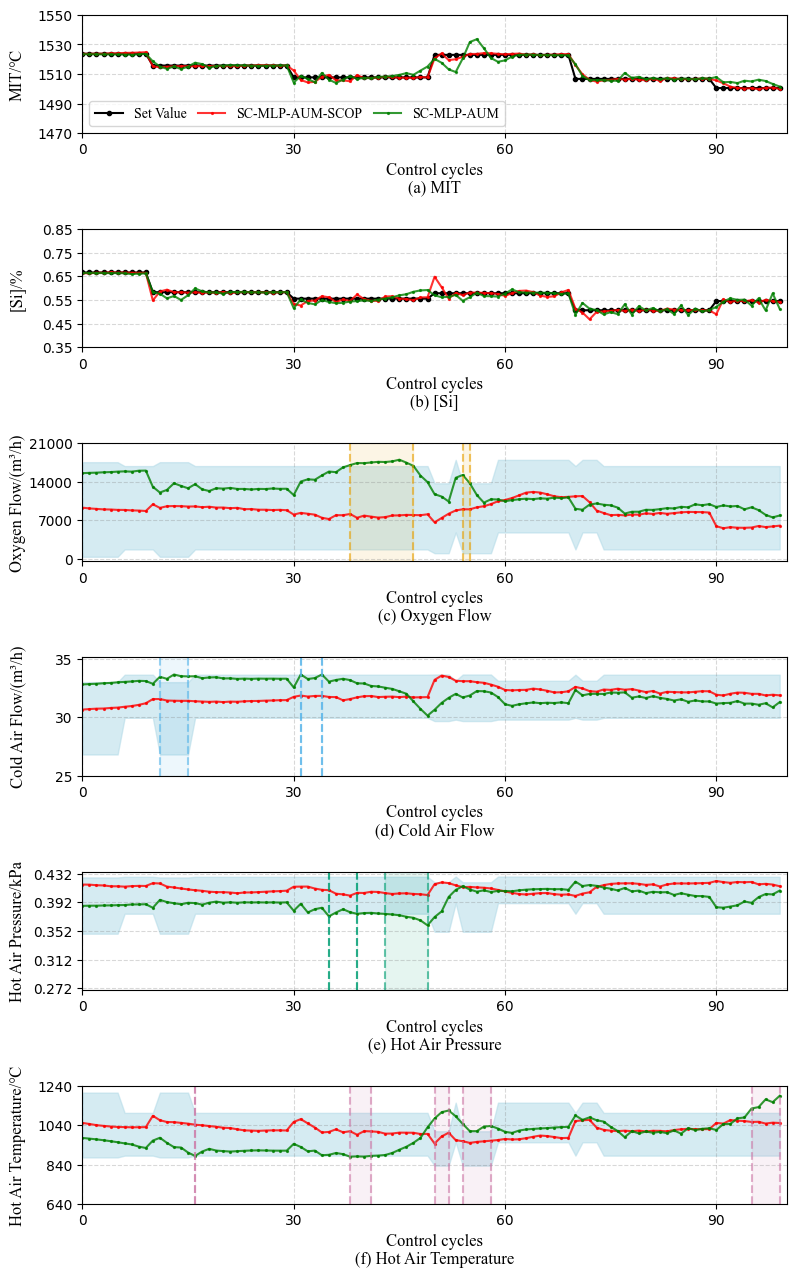

In [67]:
plt.figure(figsize=(8, 13))
time = np.arange(0, endd-startt)

# 第一个维度的曲线
# -----------------------------------------------------------------
ax = plt.subplot(6, 1, 1)

# ---- 绘制设定值 ----
plt.plot(exp_SC_MLP_AUM_SCOP.set_y1[startt:endd],    label='Set Value',                 color='k', linewidth=1.5, alpha=1.0, linestyle='-', marker='o', markersize=3.0)

# ---- 绘制四种模型预测曲线 ----
plt.plot(exp_SC_MLP_AUM_SCOP.y1_pred_inverse,     label=exp_SC_MLP_AUM_SCOP.method_label,   color='r', linewidth=1.5, alpha=0.8, linestyle='-', marker='o', markersize=1.3)
plt.plot(exp_SC_MLP_AUM.y1_pred_inverse,          label=exp_SC_MLP_AUM.method_label,        color='g', linewidth=1.5, alpha=0.8, linestyle='-', marker='o', markersize=1.3)





# ---- 辅助线与网格 ----
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
plt.grid(linestyle='--', alpha=0.3, color='gray')

# ---- 坐标范围与刻度 ----
plt.xlim(0, endd - startt)
plt.xticks(range(0, endd - startt + 1, 30))
plt.ylim([1470, 1550])
plt.yticks(range(1470, 1551, 20))


# ---- 坐标标签与标题 ----
plt.ylabel('MIT/℃', fontproperties=font_en)           # 纵坐标标签（英文）


ax.set_xlabel('Control cycles', fontproperties=font_en) # 横坐标标签
ax.yaxis.set_label_coords(-0.08, 0.5)                   # 纵轴标题靠左对齐

# ---- 子图标题 ----
ax.text(    0.5, dtiem,     f'{subplot_labels[0]} {output_term333[0]}',    transform=ax.transAxes,    ha='center',     fontproperties=font_en)

# -----------------------------------------------------------------





# ---- 图例 ----
# 设置更小的字号，比如8号

font_legend = deepcopy(font_en)
font_legend.set_size(10)

plt.legend(
    prop=font_legend,   # 使用较小字体
    ncol=3,             # ← 设置两列排列
    loc='best',         # 自动选择最合适的位置
    columnspacing=0.8,  # 两列之间的间距（可调）
    labelspacing=0.4    # 行间距（可调）
)




# 第二个维度的曲线
# -----------------------------------------------------------------
ax = plt.subplot(6, 1, 2)

# ---- 绘制设定值 ----
plt.plot(exp_SC_MLP_AUM_SCOP.set_y2[startt:endd],    label='Set Value',                 color='k', linewidth=1.5, alpha=1.0, linestyle='-', marker='o', markersize=3.0)

# ---- 绘制四种模型预测曲线 ----
plt.plot(exp_SC_MLP_AUM_SCOP.y2_pred_inverse,  label=exp_SC_MLP_AUM_SCOP.method_label,  color='r', linewidth=1.5, alpha=0.8, linestyle='-', marker='o', markersize=1.3)
plt.plot(exp_SC_MLP_AUM.y2_pred_inverse,       label=exp_SC_MLP_AUM.method_label,       color='g', linewidth=1.5, alpha=0.8, linestyle='-', marker='o', markersize=1.3)



# ---- 辅助线与网格 ----
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
plt.grid(linestyle='--', alpha=0.3, color='gray')

# ---- 坐标范围与刻度 ----
plt.xlim(0, endd - startt)
plt.xticks(range(0, endd - startt + 1, 30))
plt.ylim([0.35, 0.85])
plt.yticks(np.arange(0.35, 0.86, 0.1))


# ---- 坐标标签与标题 ----
plt.ylabel('[Si]/%', fontproperties=font_en)           # 纵坐标标签（英文）


ax.set_xlabel('Control cycles', fontproperties=font_en) # 横坐标标签
ax.yaxis.set_label_coords(-0.08, 0.5)                   # 纵轴标题靠左对齐

# ---- 子图标题 ----
ax.text(    0.5, dtiem,     f'{subplot_labels[1]} {output_term333[1]}',    transform=ax.transAxes,    ha='center',     fontproperties=font_en)

# -----------------------------------------------------------------






# u1曲线
# -----------------------------------------------------------------
ax = plt.subplot(6, 1, 3)


# ---- 绘制四种模型预测曲线 ----
plt.plot(exp_SC_MLP_AUM_SCOP.u1_pred_inverse,  label=exp_SC_MLP_AUM_SCOP.method_label,  color='r', linewidth=1.5, alpha=0.8, linestyle='-', marker='o', markersize=1.3)
plt.plot(exp_SC_MLP_AUM.u1_pred_inverse,       label=exp_SC_MLP_AUM.method_label,       color='g', linewidth=1.5, alpha=0.8, linestyle='-', marker='o', markersize=1.3)

plt.fill_between(time, exp_SC_MLP_AUM_SCOP.u1_lower_inverse, exp_SC_MLP_AUM_SCOP.u1_upper_inverse, color='lightblue', alpha=0.5, label='u1 Limits')

mark_out_of_bounds(
    ax,
    time,
    exp_SC_MLP_AUM.u1_pred_inverse,
    exp_SC_MLP_AUM_SCOP.u1_lower_inverse,
    exp_SC_MLP_AUM_SCOP.u1_upper_inverse,
    color=colors[0],   # 橙色 #E69F00
    alpha=0.6
)


# ---- 辅助线与网格 ----
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
plt.grid(linestyle='--', alpha=0.3, color='gray')

# ---- 坐标范围与刻度 ----
plt.xlim(0, endd - startt)
plt.xticks(range(0, endd - startt + 1, 30))
plt.ylim([-500, 21000])
plt.yticks(np.arange(0, 21001, 7000))


# ---- 坐标标签与标题 ----
plt.ylabel(input_term222[0], fontproperties=font_en)           # 纵坐标标签（英文）


ax.set_xlabel('Control cycles', fontproperties=font_en) # 横坐标标签
ax.yaxis.set_label_coords(-0.08, 0.5)                   # 纵轴标题靠左对齐

# ---- 子图标题 ----
ax.text(    0.5, dtiem,     f'{subplot_labels[2]} {input_term333[0]}',    transform=ax.transAxes,    ha='center',     fontproperties=font_en)


# -----------------------------------------------------------------





# u2曲线
# -----------------------------------------------------------------
ax = plt.subplot(6, 1, 4)


# ---- 绘制四种模型预测曲线 ----
plt.plot(exp_SC_MLP_AUM_SCOP.u2_pred_inverse,  label=exp_SC_MLP_AUM_SCOP.method_label,  color='r', linewidth=1.5, alpha=0.8, linestyle='-', marker='o', markersize=1.3)
plt.plot(exp_SC_MLP_AUM.u2_pred_inverse,       label=exp_SC_MLP_AUM.method_label,       color='g', linewidth=1.5, alpha=0.8, linestyle='-', marker='o', markersize=1.3)

plt.fill_between(time, exp_SC_MLP_AUM_SCOP.u2_lower_inverse, exp_SC_MLP_AUM_SCOP.u2_upper_inverse, color='lightblue', alpha=0.5, label='u2 Limits')
mark_out_of_bounds(
    ax,
    time,
    exp_SC_MLP_AUM.u2_pred_inverse,
    exp_SC_MLP_AUM_SCOP.u2_lower_inverse,
    exp_SC_MLP_AUM_SCOP.u2_upper_inverse,
    color=colors[1],   # 蓝色 #56B4E9
    alpha=0.6
)


# ---- 辅助线与网格 ----
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
plt.grid(linestyle='--', alpha=0.3, color='gray')

# ---- 坐标范围与刻度 ----
plt.xlim(0, endd - startt)
plt.xticks(range(0, endd - startt + 1, 30))
plt.ylim([25, 35.1])
plt.yticks(np.arange(25, 36, 5))


# ---- 坐标标签与标题 ----
plt.ylabel(input_term222[1], fontproperties=font_en)           # 纵坐标标签（英文）


ax.set_xlabel('Control cycles', fontproperties=font_en) # 横坐标标签
ax.yaxis.set_label_coords(-0.08, 0.5)                   # 纵轴标题靠左对齐

# ---- 子图标题 ----
ax.text(    0.5, dtiem,     f'{subplot_labels[3]} {input_term333[1]}',    transform=ax.transAxes,    ha='center',     fontproperties=font_en)



# -----------------------------------------------------------------








# u3曲线
# -----------------------------------------------------------------
ax = plt.subplot(6, 1, 5)


# ---- 绘制四种模型预测曲线 ----
plt.plot(exp_SC_MLP_AUM_SCOP.u3_pred_inverse,   label=exp_SC_MLP_AUM_SCOP.method_label, color='r', linewidth=1.5, alpha=0.8, linestyle='-', marker='o', markersize=1.3)
plt.plot(exp_SC_MLP_AUM.u3_pred_inverse,        label=exp_SC_MLP_AUM.method_label,      color='g', linewidth=1.5, alpha=0.8, linestyle='-', marker='o', markersize=1.3)

plt.fill_between(time, exp_SC_MLP_AUM_SCOP.u3_lower_inverse, exp_SC_MLP_AUM_SCOP.u3_upper_inverse, color='lightblue', alpha=0.5, label='u3 Limits')
mark_out_of_bounds(
    ax,
    time,
    exp_SC_MLP_AUM.u3_pred_inverse,
    exp_SC_MLP_AUM_SCOP.u3_lower_inverse,
    exp_SC_MLP_AUM_SCOP.u3_upper_inverse,
    color=colors[2],   # 绿色 #009E73
    alpha=0.6
)



# ---- 辅助线与网格 ----
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
plt.grid(linestyle='--', alpha=0.3, color='gray')

# ---- 坐标范围与刻度 ----
plt.xlim(0, endd - startt)
plt.xticks(range(0, endd - startt + 1, 30))
plt.ylim([0.270, 0.435])
plt.yticks(np.arange(0.272, 0.4321, 0.040))


# ---- 坐标标签与标题 ----
plt.ylabel(input_term222[2], fontproperties=font_en)           # 纵坐标标签（英文）


ax.set_xlabel('Control cycles', fontproperties=font_en) # 横坐标标签
ax.yaxis.set_label_coords(-0.08, 0.5)                   # 纵轴标题靠左对齐

# ---- 子图标题 ----
ax.text(    0.5, dtiem,     f'{subplot_labels[4]} {input_term333[2]}',    transform=ax.transAxes,    ha='center',     fontproperties=font_en)



# -----------------------------------------------------------------










# u4曲线
# -----------------------------------------------------------------
ax = plt.subplot(6, 1, 6)


# ---- 绘制四种模型预测曲线 ----
plt.plot(exp_SC_MLP_AUM_SCOP.u4_pred_inverse,  label=exp_SC_MLP_AUM_SCOP.method_label,  color='r', linewidth=1.5, alpha=0.8, linestyle='-', marker='o', markersize=1.3)
plt.plot(exp_SC_MLP_AUM.u4_pred_inverse,       label=exp_SC_MLP_AUM.method_label,       color='g', linewidth=1.5, alpha=0.8, linestyle='-', marker='o', markersize=1.3)

plt.fill_between(time, exp_SC_MLP_AUM_SCOP.u4_lower_inverse, exp_SC_MLP_AUM_SCOP.u4_upper_inverse, color='lightblue', alpha=0.5, label='u4 Limits')

mark_out_of_bounds(
    ax,
    time,
    exp_SC_MLP_AUM.u4_pred_inverse,
    exp_SC_MLP_AUM_SCOP.u4_lower_inverse,
    exp_SC_MLP_AUM_SCOP.u4_upper_inverse,
    color=colors[3],   # 紫红色 #CC79A7
    alpha=0.6
)


# ---- 辅助线与网格 ----
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
plt.grid(linestyle='--', alpha=0.3, color='gray')

# ---- 坐标范围与刻度 ----
plt.xlim(0, endd - startt)
plt.xticks(range(0, endd - startt + 1, 30))
plt.ylim([640, 1240])
plt.yticks(np.arange(640, 1241, 200))


# ---- 坐标标签与标题 ----
plt.ylabel(input_term222[3], fontproperties=font_en)           # 纵坐标标签（英文）


ax.set_xlabel('Control cycles', fontproperties=font_en) # 横坐标标签
ax.yaxis.set_label_coords(-0.08, 0.5)                   # 纵轴标题靠左对齐

# ---- 子图标题 ----
ax.text(    0.5, dtiem,     f'{subplot_labels[5]} {input_term333[3]}',    transform=ax.transAxes,    ha='center',     fontproperties=font_en)



# -----------------------------------------------------------------













# 调整子图布局
plt.tight_layout()











plt.savefig(
    '两组实验数据.png',   # 保存文件名
    dpi=300,                # 分辨率（默认100，600已经是印刷级）
    bbox_inches='tight',    # 自动裁剪空白边
    pad_inches=0.1,         # 四周留少量空白
    transparent=False       # 是否透明背景
)



plt.show()